# Real Estate Data Processing Pipeline

This notebook demonstrates the implementation and usage of the RealEstateDataset class for processing real estate data.

## Objectives:
1. Implement the RealEstateDataset class
2. Load and explore the housing dataset
3. Clean and preprocess the data
4. Generate insights and visualizations
5. Save the cleaned dataset

## 1. Install Required Packages

First, let's install the necessary Python packages for our real estate data analysis.

In [1]:
# Install required packages
import subprocess
import sys

def install_packages():
    packages = [
        'pandas>=1.5.0',
        'numpy>=1.21.0',
        'matplotlib>=3.5.0',
        'seaborn>=0.11.0'
    ]
    
    for package in packages:
        try:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
            print(f"✅ Successfully installed {package}")
        except subprocess.CalledProcessError as e:
            print(f"❌ Failed to install {package}: {e}")

# Uncomment the line below to install packages
# install_packages()

## 2. Import Required Libraries

Import all necessary libraries for data processing and analysis.

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Dict, Any
import warnings
import os

# Configure display settings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("📚 Libraries imported successfully!")
print(f"🐼 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

📚 Libraries imported successfully!
🐼 Pandas version: 2.3.2
🔢 NumPy version: 2.3.2


## 3. RealEstateDataset Class Implementation

Here we implement the RealEstateDataset class with the required methods.

In [3]:
class RealEstateDataset:
    """
    A class for handling real estate data processing including loading,
    cleaning, and analyzing real estate datasets.
    """
    
    def __init__(self):
        """Initialize the RealEstateDataset instance."""
        self.data: Optional[pd.DataFrame] = None
        self.original_data: Optional[pd.DataFrame] = None
        self.filepath: Optional[str] = None
    
    def load_data(self, filepath: str) -> pd.DataFrame:
        """
        Read the dataset and initialize a pandas DataFrame.
        
        Args:
            filepath (str): Path to the CSV file containing real estate data
            
        Returns:
            pd.DataFrame: Loaded dataset
        """
        try:
            self.filepath = filepath
            self.data = pd.read_csv(filepath)
            # Keep a copy of original data for comparison
            self.original_data = self.data.copy()
            
            print(f"✅ Data loaded successfully from {filepath}")
            print(f"📊 Dataset shape: {self.data.shape}")
            print("\n🔍 First 5 rows:")
            display(self.data.head())
            print("\n📋 Column names:")
            print(self.data.columns.tolist())
            print("\n🏷️  Data types:")
            print(self.data.dtypes)
            
            return self.data
            
        except FileNotFoundError:
            print(f"❌ Error: File '{filepath}' not found.")
            raise
        except Exception as e:
            print(f"❌ Error loading data: {str(e)}")
            raise
    
    def clean_data(self) -> pd.DataFrame:
        """
        Handle missing and invalid data.
        
        Returns:
            pd.DataFrame: Cleaned dataset
        """
        if self.data is None:
            raise ValueError("❌ No data loaded. Please call load_data() first.")
        
        print("🧹 Starting data cleaning process...")
        
        # Store initial state
        initial_rows = len(self.data)
        
        # 1. Handle missing values
        print("\n📊 Missing values before cleaning:")
        missing_before = self.data.isnull().sum()
        print(missing_before[missing_before > 0])
        
        # Numerical columns - fill with median
        numerical_cols = self.data.select_dtypes(include=[np.number]).columns
        for col in numerical_cols:
            if self.data[col].isnull().sum() > 0:
                median_val = self.data[col].median()
                self.data[col] = self.data[col].fillna(median_val)
                print(f"   ✓ Filled {col} missing values with median: {median_val:.2f}")
        
        # Categorical columns - fill with mode or drop
        categorical_cols = self.data.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if self.data[col].isnull().sum() > 0:
                if self.data[col].isnull().sum() / len(self.data) > 0.5:
                    # If more than 50% missing, drop the column
                    self.data = self.data.drop(columns=[col])
                    print(f"   ✓ Dropped column '{col}' (>50% missing)")
                else:
                    # Fill with mode
                    mode_val = self.data[col].mode()[0] if not self.data[col].mode().empty else 'Unknown'
                    self.data[col] = self.data[col].fillna(mode_val)
                    print(f"   ✓ Filled {col} missing values with mode: '{mode_val}'")
        
        # 2. Handle invalid entries
        print("\n🔍 Checking for invalid entries...")
        
        # Remove negative prices
        if 'Price' in self.data.columns:
            negative_prices = self.data['Price'] < 0
            if negative_prices.sum() > 0:
                self.data = self.data[~negative_prices]
                print(f"   ✓ Removed {negative_prices.sum()} rows with negative prices")
        
        # Remove invalid room counts
        for col in ['Bedrooms', 'Bathrooms']:
            if col in self.data.columns:
                invalid_rooms = self.data[col] < 0
                if invalid_rooms.sum() > 0:
                    self.data = self.data[~invalid_rooms]
                    print(f"   ✓ Removed {invalid_rooms.sum()} rows with negative {col}")
        
        # Remove invalid sizes
        if 'Size_sqft' in self.data.columns:
            invalid_size = self.data['Size_sqft'] <= 0
            if invalid_size.sum() > 0:
                self.data = self.data[~invalid_size]
                print(f"   ✓ Removed {invalid_size.sum()} rows with invalid size")
        
        # 3. Fix data types
        print("\n🔧 Fixing data types...")
        
        # Convert date columns
        date_columns = ['Date_Added']
        for col in date_columns:
            if col in self.data.columns:
                try:
                    self.data[col] = pd.to_datetime(self.data[col], errors='coerce')
                    print(f"   ✓ Converted {col} to datetime")
                except:
                    print(f"   ⚠️  Could not convert {col} to datetime")
        
        # 4. Remove duplicates
        duplicates = self.data.duplicated().sum()
        if duplicates > 0:
            self.data = self.data.drop_duplicates()
            print(f"   ✓ Removed {duplicates} duplicate rows")
        
        # 5. Reset index
        self.data = self.data.reset_index(drop=True)
        
        # Summary
        final_rows = len(self.data)
        rows_removed = initial_rows - final_rows
        
        print(f"\n✅ Data cleaning completed!")
        print(f"📊 Initial rows: {initial_rows}")
        print(f"📊 Final rows: {final_rows}")
        print(f"📊 Rows removed: {rows_removed}")
        
        return self.data
    
    def describe_data(self) -> Dict[str, Any]:
        """
        Print basic statistics and exploratory insights.
        
        Returns:
            Dict: Dictionary containing various statistics and insights
        """
        if self.data is None:
            raise ValueError("❌ No data loaded. Please call load_data() first.")
        
        print("📈 REAL ESTATE DATA ANALYSIS REPORT")
        print("=" * 50)
        
        # Basic info
        print(f"\n📊 DATASET OVERVIEW")
        print(f"   • Total properties: {len(self.data):,}")
        print(f"   • Number of features: {len(self.data.columns)}")
        
        # Descriptive statistics
        numerical_cols = self.data.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) > 0:
            print(f"\n📊 NUMERICAL STATISTICS")
            display(self.data[numerical_cols].describe())
        
        insights = {}
        
        # Property type analysis
        if 'Type' in self.data.columns:
            print(f"\n🏠 PROPERTY TYPE DISTRIBUTION")
            type_counts = self.data['Type'].value_counts()
            type_percentages = self.data['Type'].value_counts(normalize=True) * 100
            
            for prop_type, count in type_counts.items():
                percentage = type_percentages[prop_type]
                print(f"   • {prop_type}: {count:,} ({percentage:.1f}%)")
            
            insights['property_types'] = type_counts.to_dict()
        
        # Price analysis by property type
        if 'Price' in self.data.columns and 'Type' in self.data.columns:
            print(f"\n💰 AVERAGE PRICES BY PROPERTY TYPE")
            avg_prices = self.data.groupby('Type')['Price'].agg(['mean', 'median', 'count'])
            display(avg_prices)
            
            insights['avg_prices_by_type'] = avg_prices['mean'].to_dict()
        
        # Size analysis by location
        if 'Size_sqft' in self.data.columns and 'Location' in self.data.columns:
            print(f"\n📏 AVERAGE SIZE BY LOCATION (Top 10)")
            avg_size = self.data.groupby('Location')['Size_sqft'].agg(['mean', 'count']).sort_values('mean', ascending=False)
            display(avg_size.head(10))
            
            insights['avg_size_by_location'] = avg_size['mean'].head(10).to_dict()
        
        return insights
    
    def save_cleaned_data(self, output_path: str) -> None:
        """
        Save the cleaned dataset to a CSV file.
        
        Args:
            output_path (str): Path where to save the cleaned data
        """
        if self.data is None:
            raise ValueError("❌ No data to save. Please load and clean data first.")
        
        try:
            # Ensure directory exists
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            
            self.data.to_csv(output_path, index=False)
            print(f"✅ Cleaned data saved to: {output_path}")
            print(f"📊 Saved {len(self.data)} rows and {len(self.data.columns)} columns")
        except Exception as e:
            print(f"❌ Error saving data: {str(e)}")
            raise

print("🏗️  RealEstateDataset class defined successfully!")

🏗️  RealEstateDataset class defined successfully!


## 4. Data Loading and Initial Exploration

Now let's create an instance of our RealEstateDataset class and load the housing data.

In [4]:
# Create an instance of RealEstateDataset
dataset = RealEstateDataset()

# Load the housing data
data_path = '../data/raw/housing_data.csv'
dataset.load_data(data_path)

✅ Data loaded successfully from ../data/raw/housing_data.csv
📊 Dataset shape: (10000, 18)

🔍 First 5 rows:


,Property_ID,Location,Type,Price,Bedrooms,Bathrooms,Size_sqft,Year_Built,Sold,Date_Added,Agent_ID,Listing_Type,HOA_Fee,Parking_Spaces,Garage,Pool,Lot_Size_acres,Days_on_Market
0,PROP00001,Chicago,House,327539.000,2.0,3.0,1572.000000,1959,0,5/13/2024,AGT0007,For Rent,0.0,2,0,0,0.05,171
1,PROP00002,Miami,House,391371.000,5.0,3.0,2197.000000,1970,0,5/14/2025,AGT0053,For Rent,300.0,2,1,0,0.58,214
2,PROP00003,Los Angeles,Condo,318609.000,3.0,3.0,1630.000000,2019,1,4/1/2025,AGT0075,For Rent,NaN,1,0,0,0.11,180
3,PROP00004,Miami,Apartment,429625.000,1.0,3.0,1233.000000,1983,0,11/17/2023,AGT0114,For Rent,NaN,1,1,1,0.49,76
4,PROP00005,Miami,Condo,3016324.057,1.0,0.0,7467.705263,1961,0,4/24/2025,AGT0063,For Sale,300.0,0,1,1,0.60,78



📋 Column names:
['Property_ID', 'Location', 'Type', 'Price', 'Bedrooms', 'Bathrooms', 'Size_sqft', 'Year_Built', 'Sold', 'Date_Added', 'Agent_ID', 'Listing_Type', 'HOA_Fee', 'Parking_Spaces', 'Garage', 'Pool', 'Lot_Size_acres', 'Days_on_Market']

🏷️  Data types:
Property_ID        object
Location           object
Type               object
Price             float64
Bedrooms          float64
Bathrooms         float64
Size_sqft         float64
Year_Built          int64
Sold                int64
Date_Added         object
Agent_ID           object
Listing_Type       object
HOA_Fee           float64
Parking_Spaces      int64
Garage              int64
Pool                int64
Lot_Size_acres    float64
Days_on_Market      int64
dtype: object


,Property_ID,Location,Type,Price,Bedrooms,Bathrooms,Size_sqft,Year_Built,Sold,Date_Added,Agent_ID,Listing_Type,HOA_Fee,Parking_Spaces,Garage,Pool,Lot_Size_acres,Days_on_Market
0,PROP00001,Chicago,House,327539.000,2.0,3.0,1572.000000,1959,0,5/13/2024,AGT0007,For Rent,0.0,2,0,0,0.05,171
1,PROP00002,Miami,House,391371.000,5.0,3.0,2197.000000,1970,0,5/14/2025,AGT0053,For Rent,300.0,2,1,0,0.58,214
2,PROP00003,Los Angeles,Condo,318609.000,3.0,3.0,1630.000000,2019,1,4/1/2025,AGT0075,For Rent,NaN,1,0,0,0.11,180
3,PROP00004,Miami,Apartment,429625.000,1.0,3.0,1233.000000,1983,0,11/17/2023,AGT0114,For Rent,NaN,1,1,1,0.49,76
4,PROP00005,Miami,Condo,3016324.057,1.0,0.0,7467.705263,1961,0,4/24/2025,AGT0063,For Sale,300.0,0,1,1,0.60,78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,PROP09996,San Francisco,Condo,390727.000,NaN,2.0,1060.000000,1964,0,4/10/2024,AGT0078,For Rent,0.0,3,0,0,0.53,228
9996,PROP09997,Los Angeles,House,350478.000,2.0,4.0,2745.000000,1953,1,6/12/2024,AGT0168,For Rent,300.0,1,0,0,0.30,178
9997,PROP09998,San Francisco,House,232412.000,2.0,2.0,2381.000000,1968,1,10/21/2023,AGT0084,For Rent,200.0,1,0,0,0.15,259
9998,PROP09999,Chicago,House,317020.000,4.0,2.0,2469.000000,2013,0,3/2/2024,AGT0116,For Rent,0.0,3,1,1,0.50,135


## 5. Data Cleaning

Clean the dataset by handling missing values and invalid entries.

In [5]:
# Clean the data
cleaned_data = dataset.clean_data()

# Check for any remaining missing values
print("\n📊 Missing values after cleaning:")
missing_after = dataset.data.isnull().sum()
remaining_missing = missing_after[missing_after > 0]
if len(remaining_missing) == 0:
    print("   ✅ No missing values remaining!")
else:
    print(remaining_missing)

🧹 Starting data cleaning process...

📊 Missing values before cleaning:
Price         499
Bedrooms      500
Bathrooms     500
Size_sqft     496
HOA_Fee      2426
dtype: int64
   ✓ Filled Price missing values with median: 302198.00
   ✓ Filled Bedrooms missing values with median: 3.00
   ✓ Filled Bathrooms missing values with median: 2.00
   ✓ Filled Size_sqft missing values with median: 1505.00
   ✓ Filled HOA_Fee missing values with median: 100.00

🔍 Checking for invalid entries...
   ✓ Removed 13 rows with negative prices
   ✓ Removed 22 rows with invalid size

🔧 Fixing data types...
   ✓ Converted Date_Added to datetime

✅ Data cleaning completed!
📊 Initial rows: 10000
📊 Final rows: 9965
📊 Rows removed: 35

📊 Missing values after cleaning:
   ✅ No missing values remaining!


## 6. Data Analysis and Insights

Generate descriptive statistics and insights from the cleaned data.

In [6]:
# Generate insights
insights = dataset.describe_data()

📈 REAL ESTATE DATA ANALYSIS REPORT

📊 DATASET OVERVIEW
   • Total properties: 9,965
   • Number of features: 18

📊 NUMERICAL STATISTICS


,Price,Bedrooms,Bathrooms,Size_sqft,Year_Built,Sold,HOA_Fee,Parking_Spaces,Garage,Pool,Lot_Size_acres,Days_on_Market
count,9.965000e+03,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000,9965.000000
mean,3.157014e+05,2.992173,1.995484,1527.362395,1985.703462,0.193678,137.230306,1.506272,0.511791,0.498545,0.302213,151.109885
std,2.150491e+05,1.676142,1.380558,644.721906,20.898698,0.395199,99.187565,1.114701,0.499886,0.500023,0.201546,86.166915
min,4.730000e+02,0.000000,0.000000,15.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.410000,1.000000
25%,2.381600e+05,2.000000,1.000000,1177.000000,1968.000000,0.000000,100.000000,1.000000,0.000000,0.000000,0.170000,76.000000
50%,3.021980e+05,3.000000,2.000000,1505.000000,1986.000000,0.000000,100.000000,1.000000,1.000000,0.000000,0.300000,153.000000
75%,3.672720e+05,4.000000,3.000000,1823.000000,2004.000000,0.000000,200.000000,3.000000,1.000000,1.000000,0.440000,226.000000
max,3.016324e+06,13.000000,10.000000,7467.705263,2021.000000,1.000000,300.000000,3.000000,1.000000,1.000000,1.040000,299.000000



🏠 PROPERTY TYPE DISTRIBUTION
   • House: 3,356 (33.7%)
   • Condo: 3,315 (33.3%)
   • Apartment: 3,294 (33.1%)

💰 AVERAGE PRICES BY PROPERTY TYPE


,mean,median,count
Type,,,
Apartment,317162.090527,302198.0,3294
Condo,311931.757371,302198.0,3315
House,317991.151361,302198.0,3356



📏 AVERAGE SIZE BY LOCATION (Top 10)


,mean,count
Location,,
San Francisco,1541.435490,2008
Los Angeles,1541.294236,1935
New York,1521.136177,2041
Miami,1518.557785,2017
Chicago,1514.760419,1964


## 7. Data Visualizations

Create visualizations to better understand the real estate market data.

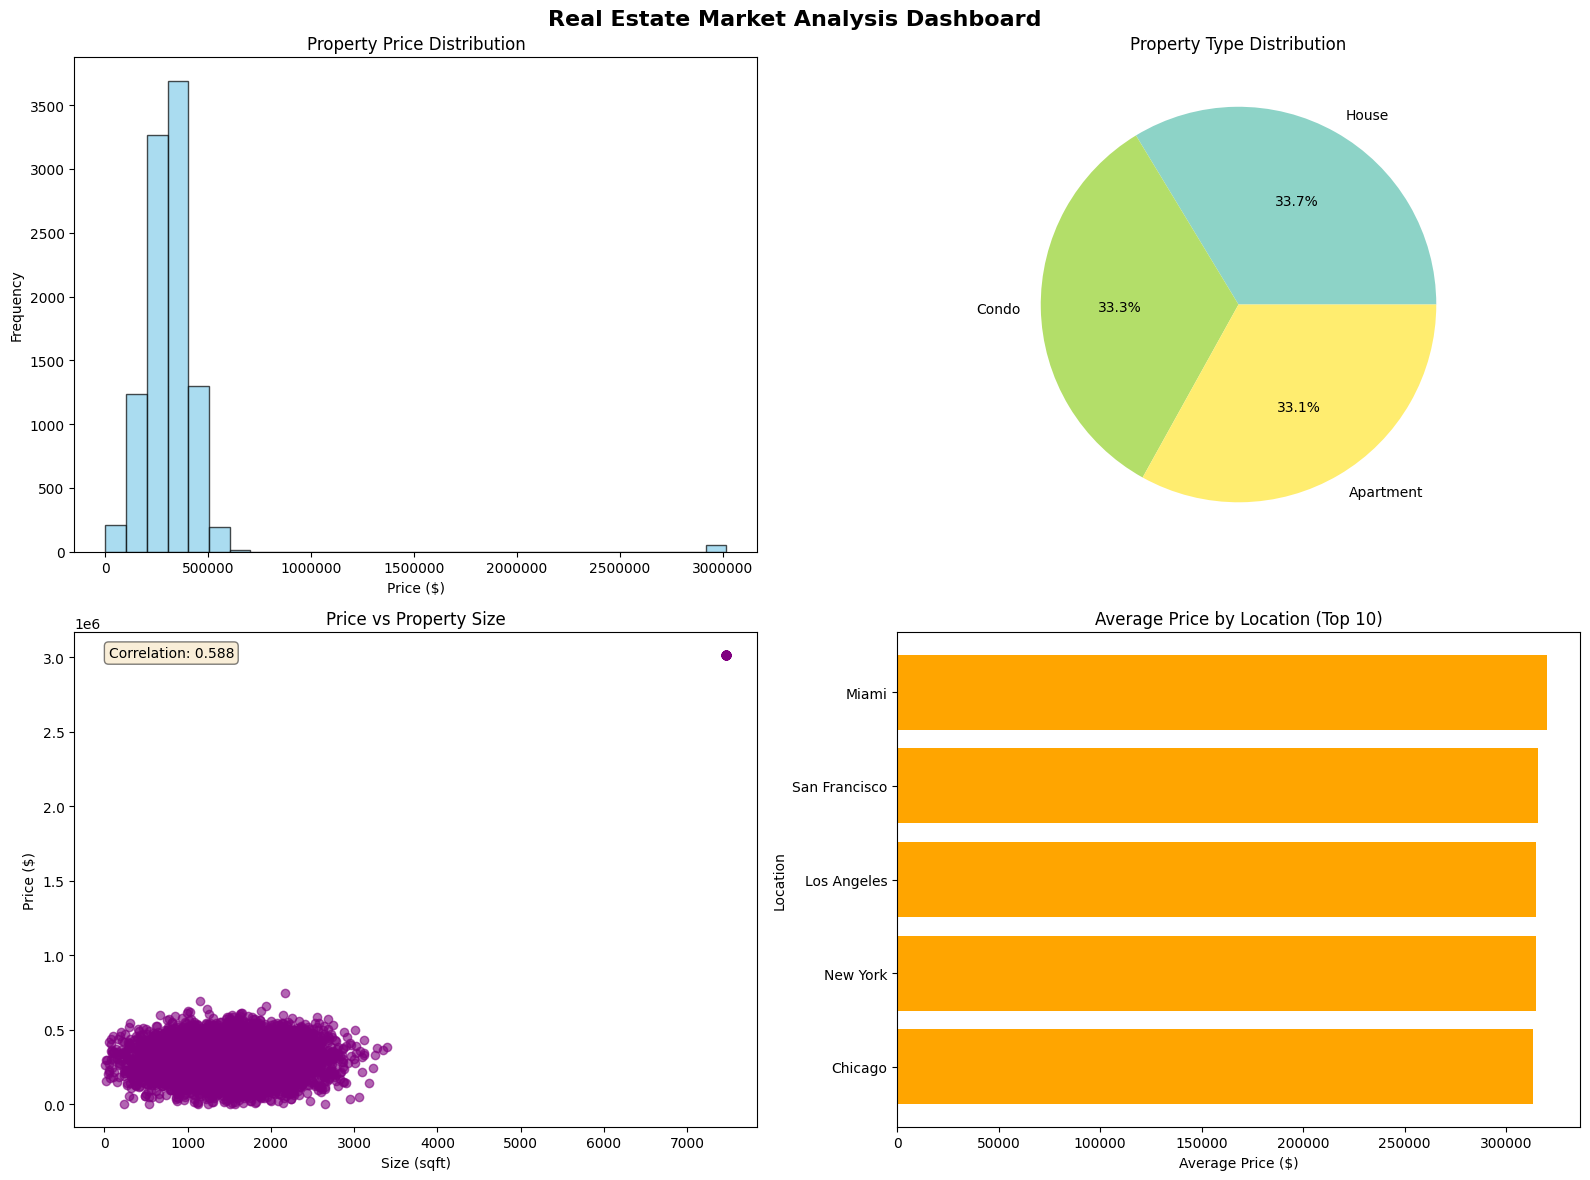

📊 Visualizations created successfully!


In [7]:
# Create comprehensive visualizations
def create_real_estate_visualizations(data):
    """
    Create comprehensive visualizations for real estate data analysis.
    """
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Real Estate Market Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Price distribution
    if 'Price' in data.columns:
        axes[0, 0].hist(data['Price'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[0, 0].set_title('Property Price Distribution')
        axes[0, 0].set_xlabel('Price ($)')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].ticklabel_format(style='plain', axis='x')
    
    # 2. Property type distribution
    if 'Type' in data.columns:
        type_counts = data['Type'].value_counts()
        colors = plt.cm.Set3(np.linspace(0, 1, len(type_counts)))
        axes[0, 1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%', colors=colors)
        axes[0, 1].set_title('Property Type Distribution')
    
    # 3. Price vs Size scatter plot
    if 'Price' in data.columns and 'Size_sqft' in data.columns:
        axes[1, 0].scatter(data['Size_sqft'], data['Price'], alpha=0.6, color='purple')
        axes[1, 0].set_title('Price vs Property Size')
        axes[1, 0].set_xlabel('Size (sqft)')
        axes[1, 0].set_ylabel('Price ($)')
        
        # Add correlation coefficient
        correlation = data['Price'].corr(data['Size_sqft'])
        axes[1, 0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                       transform=axes[1, 0].transAxes, fontsize=10,
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 4. Average price by location (top 10)
    if 'Price' in data.columns and 'Location' in data.columns:
        avg_price_by_location = data.groupby('Location')['Price'].mean().sort_values(ascending=True).tail(10)
        axes[1, 1].barh(range(len(avg_price_by_location)), avg_price_by_location.values, color='orange')
        axes[1, 1].set_title('Average Price by Location (Top 10)')
        axes[1, 1].set_xlabel('Average Price ($)')
        axes[1, 1].set_ylabel('Location')
        axes[1, 1].set_yticks(range(len(avg_price_by_location)))
        axes[1, 1].set_yticklabels(avg_price_by_location.index)
    
    plt.tight_layout()
    plt.show()
    
    print("📊 Visualizations created successfully!")

# Create visualizations
create_real_estate_visualizations(dataset.data)

## 8. Additional Analysis

Let's perform some additional analysis to gain deeper insights.

🔍 ADDITIONAL INSIGHTS

📊 Correlation Matrix:


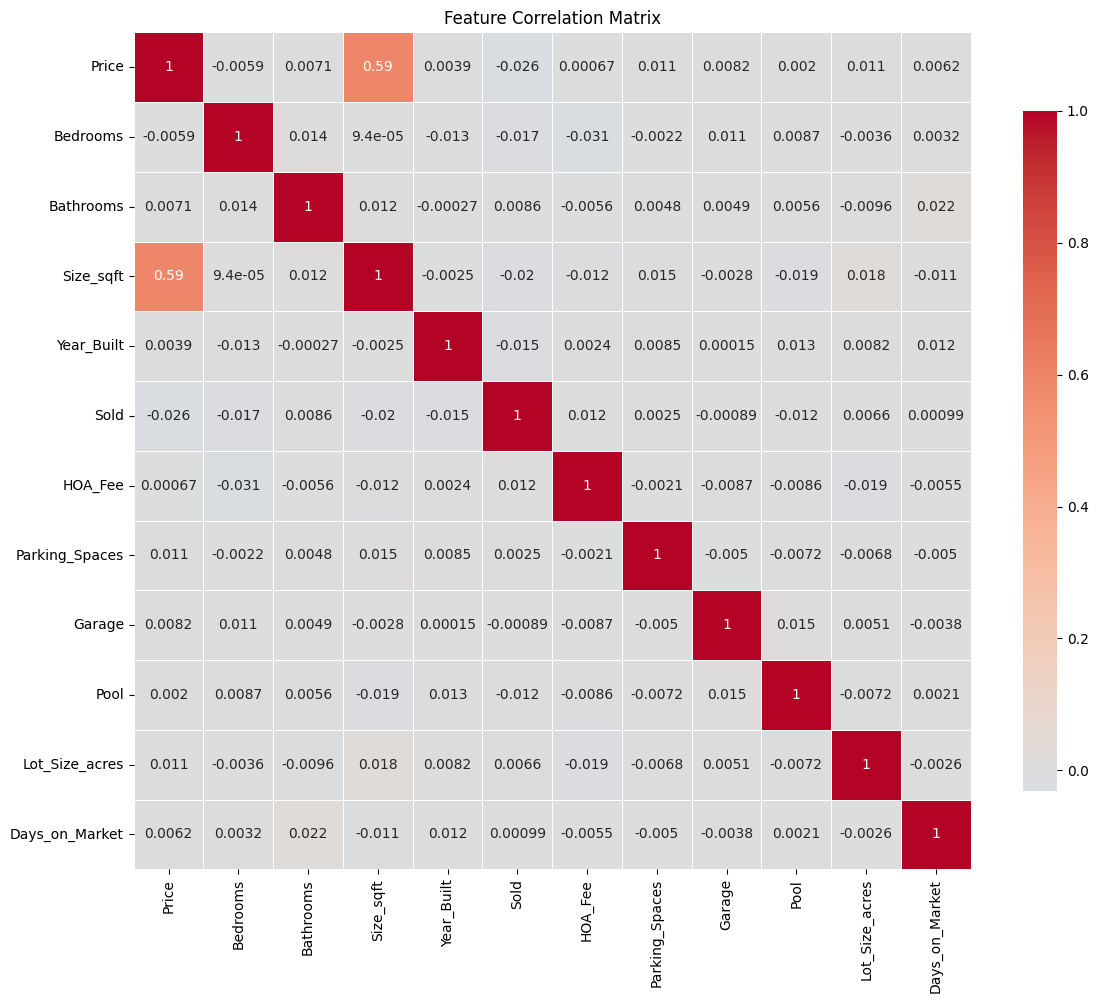


🛏️  Average Price by Number of Bedrooms:


,mean,count
Bedrooms,,
0.0,330580.474297,458
1.0,314922.377400,1416
2.0,319174.093626,2134
3.0,312232.482921,2660
4.0,318105.536938,1569
5.0,307076.988419,940
6.0,312512.729311,502
7.0,287936.983784,185
8.0,360294.705852,61



📅 Properties Listed by Year:


Year_Added
2023    2693
2024    4990
2025    2282
Name: count, dtype: int64


✅ Additional analysis completed!


In [8]:
# Additional analysis
print("🔍 ADDITIONAL INSIGHTS\n")

# Correlation matrix for numerical features
numerical_cols = dataset.data.select_dtypes(include=[np.number]).columns
if len(numerical_cols) > 1:
    print("📊 Correlation Matrix:")
    correlation_matrix = dataset.data[numerical_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

# Price analysis by bedrooms
if 'Price' in dataset.data.columns and 'Bedrooms' in dataset.data.columns:
    print("\n🛏️  Average Price by Number of Bedrooms:")
    price_by_bedrooms = dataset.data.groupby('Bedrooms')['Price'].agg(['mean', 'count']).sort_index()
    display(price_by_bedrooms)

# Market trends (if date information is available)
if 'Date_Added' in dataset.data.columns:
    dataset.data['Year_Added'] = dataset.data['Date_Added'].dt.year
    if not dataset.data['Year_Added'].isnull().all():
        print("\n📅 Properties Listed by Year:")
        yearly_counts = dataset.data['Year_Added'].value_counts().sort_index()
        display(yearly_counts)

print("\n✅ Additional analysis completed!")

## 9. Save Cleaned Dataset

Save the cleaned dataset for future use.

In [9]:
# Save the cleaned dataset
output_path = '../data/cleaned/housing_data_cleaned.csv'
dataset.save_cleaned_data(output_path)

print("\n🎉 Real Estate Data Processing Pipeline completed successfully!")
print("\n📋 Summary:")
print(f"   • Original dataset: {len(dataset.original_data)} rows")
print(f"   • Cleaned dataset: {len(dataset.data)} rows")
print(f"   • Data quality improved: {((len(dataset.data)/len(dataset.original_data)) * 100):.1f}% data retained")
print(f"   • Cleaned data saved to: {output_path}")

✅ Cleaned data saved to: ../data/cleaned/housing_data_cleaned.csv
📊 Saved 9965 rows and 19 columns

🎉 Real Estate Data Processing Pipeline completed successfully!

📋 Summary:
   • Original dataset: 10000 rows
   • Cleaned dataset: 9965 rows
   • Data quality improved: 99.7% data retained
   • Cleaned data saved to: ../data/cleaned/housing_data_cleaned.csv


## 10. Test Environment Setup

Let's verify that our environment is properly configured and all components are working.

In [10]:
# Test environment setup
def test_environment():
    """
    Test that all required packages are installed and working correctly.
    """
    print("🧪 Testing Environment Setup\n")
    
    # Test package imports
    packages_to_test = {
        'pandas': pd,
        'numpy': np,
        'matplotlib': plt,
        'seaborn': sns
    }
    
    for package_name, package in packages_to_test.items():
        try:
            version = getattr(package, '__version__', 'Unknown')
            print(f"   ✅ {package_name}: {version}")
        except Exception as e:
            print(f"   ❌ {package_name}: Error - {e}")
    
    # Test RealEstateDataset class
    try:
        test_dataset = RealEstateDataset()
        print(f"   ✅ RealEstateDataset class: Working")
    except Exception as e:
        print(f"   ❌ RealEstateDataset class: Error - {e}")
    
    # Test file paths
    files_to_check = [
        '../data/raw/housing_data.csv',
        '../src/real_estate_dataset.py',
        '../requirements.txt'
    ]
    
    print("\n📁 File Structure Check:")
    for file_path in files_to_check:
        if os.path.exists(file_path):
            print(f"   ✅ {file_path}: Found")
        else:
            print(f"   ❌ {file_path}: Not found")
    
    print("\n🎯 Environment test completed!")

# Run environment test
test_environment()

🧪 Testing Environment Setup

   ✅ pandas: 2.3.2
   ✅ numpy: 2.3.2
   ✅ matplotlib: Unknown
   ✅ seaborn: 0.13.2
   ✅ RealEstateDataset class: Working

📁 File Structure Check:
   ✅ ../data/raw/housing_data.csv: Found
   ✅ ../src/real_estate_dataset.py: Found
   ✅ ../requirements.txt: Found

🎯 Environment test completed!


In [11]:
# Analysis and Visualization Classes for Advanced Market Insights
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

class Analysis:
    def __init__(self, df):
        self.df = df.copy()

    def calculate_price_per_sqft(self):
        if 'Price' in self.df.columns and 'Size_sqft' in self.df.columns:
            self.df['Price_per_sqft'] = self.df['Price'] / self.df['Size_sqft']
        else:
            raise ValueError('Required columns Price and Size_sqft not found.')
        return self.df

    def calculate_property_age(self, current_year=None):
        if current_year is None:
            from datetime import datetime
            current_year = datetime.now().year
        if 'Year_Built' in self.df.columns:
            self.df['Property_Age'] = current_year - self.df['Year_Built']
        else:
            raise ValueError('Required column Year_Built not found.')
        return self.df

class Visualization(Analysis):
    def __init__(self, df):
        super().__init__(df)

    def plot_price_distribution(self, property_type=None):
        plt.figure(figsize=(10,6))
        data = self.df
        if property_type:
            data = data[data['Type'] == property_type]
            title = f'Price Distribution for {property_type}'
        else:
            title = 'Price Distribution by Property Type'
        sns.boxplot(x='Type', y='Price_per_sqft', data=data)
        plt.title(title)
        plt.ylabel('Price per Sqft')
        plt.xlabel('Property Type')
        plt.show()

    def plot_top_locations(self, top_n=5):
        plt.figure(figsize=(10,6))
        top_locations = self.df['Location'].value_counts().nlargest(top_n)
        sns.barplot(x=top_locations.values, y=top_locations.index, palette='viridis')
        plt.title(f'Top {top_n} Locations by Number of Properties')
        plt.xlabel('Number of Properties')
        plt.ylabel('Location')
        plt.show()

    def plot_price_trends(self):
        plt.figure(figsize=(10,6))
        if 'Year_Built' in self.df.columns:
            avg_price_by_year = self.df.groupby('Year_Built')['Price'].mean()
            avg_price_by_year.plot(marker='o')
            plt.title('Average Price Trends by Year Built')
            plt.xlabel('Year Built')
            plt.ylabel('Average Price')
            plt.show()
        # Scatter plot: Price_per_sqft vs Size_sqft
        plt.figure(figsize=(10,6))
        sns.scatterplot(x='Size_sqft', y='Price_per_sqft', hue='Type', data=self.df)
        plt.title('Price per Sqft vs. Size (Colored by Property Type)')
        plt.xlabel('Size (sqft)')
        plt.ylabel('Price per Sqft')
        plt.legend()
        plt.show()

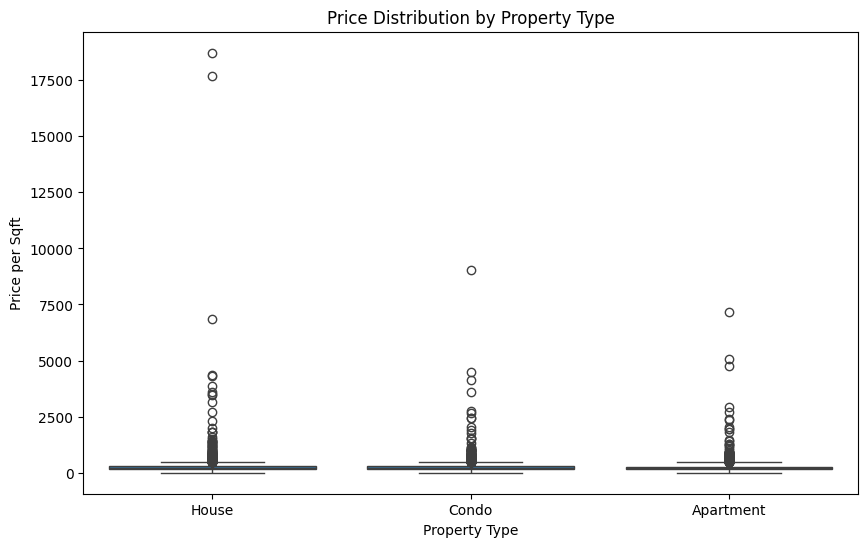

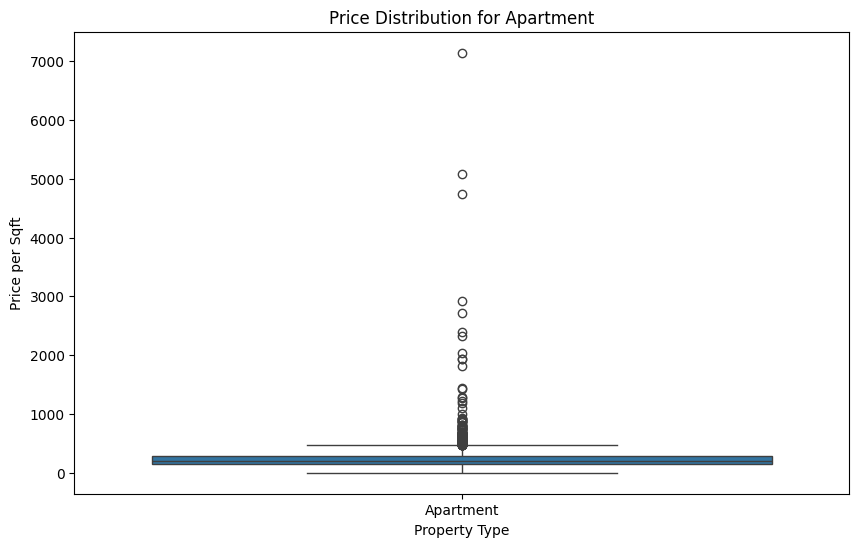

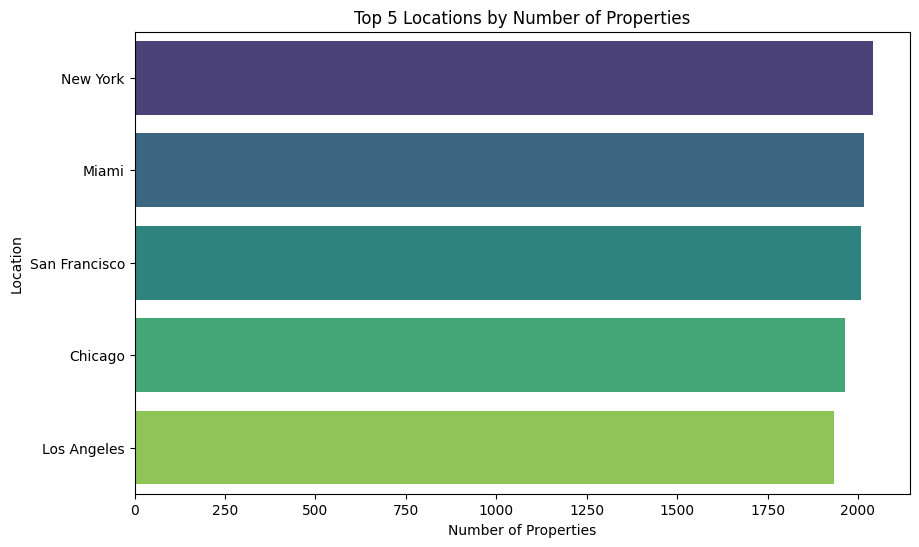

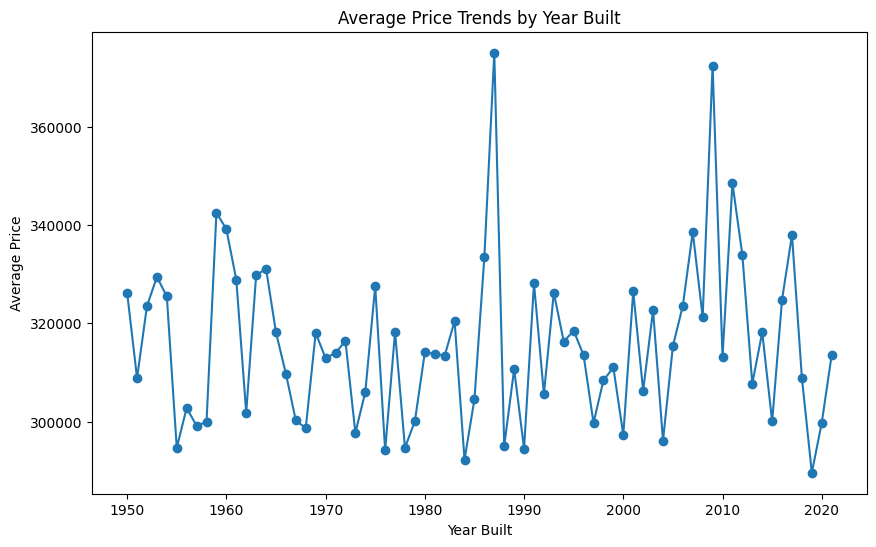

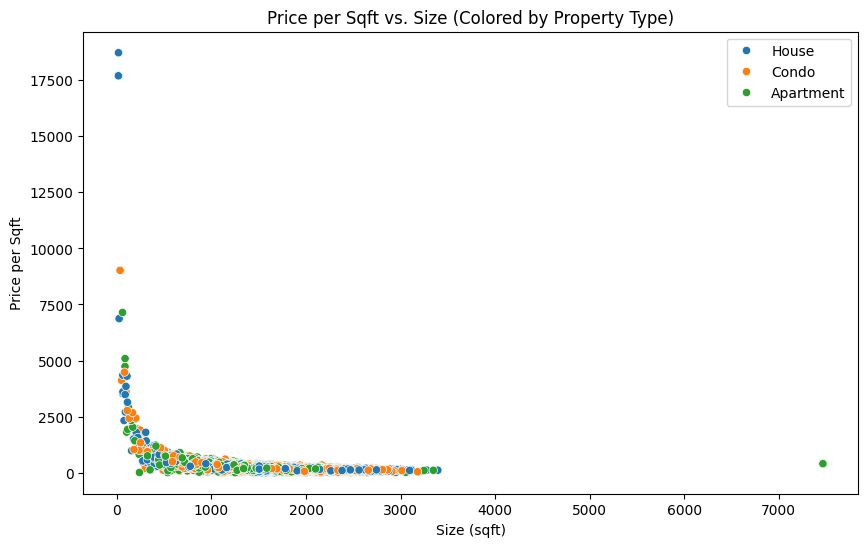

In [13]:
# Use the Analysis and Visualization classes
# Use cleaned_data from previous steps

# 1. Analysis: Calculate new columns
analysis = Analysis(cleaned_data)
df_with_price = analysis.calculate_price_per_sqft()
df_with_age = analysis.calculate_property_age()

# 2. Visualization: Inherit and plot
viz = Visualization(df_with_age)
viz.plot_price_distribution()  # Boxplot for all property types
viz.plot_price_distribution(property_type='Apartment')  # Example: only Apartments
viz.plot_top_locations(top_n=5)
viz.plot_price_trends()

## Market Trends & Insights Summary

- **Which property type has the highest price per square foot?**
- **Are older properties generally cheaper or more expensive?**
- **Top-performing locations:**

_Use the results from the above analysis and visualizations to answer these questions. Summarize your findings here._